# AirBnB Analytics Specialist Take Home Solution

**Overview and Instructions:**

AirBnB wants to understand
   - What guests are searching in Dublin
   - Which inquiries hosts tend to accept
   - What gaps exist between guest demand and host supply
   - Any other information that deepens the understanding of the data
    
Goal is to analyze, understand, visualize, and communicate the demand/supply of the market in Dublin

You should:
   - Create a pdf presentation with a maximum of 15 slides with relevant tables, graphs, visualizations
   - Attach a pdf of code
   - Take no more than 3-6 hours
    
Evaluated based on:
   - Aesthetics of presentation
   - Analysis including graphs, tables, and visualiations
   - Data decisions you made and style of coding
   - How well you followed directions

**Datasets**

There are 2 datasets
1. searches.tsv - Contains a row for each set of searches that a user does for Dublin
2. contacts.tsv - contains a row for every time that an assigned visitor makes an inquiry for a stay in a listing in Dublin

Searches dataset contains the following columns:
   - ds - Date of the search
   - id_user - Alphanumeric user_id
   - ds_checkin - Date stamp of the check-in date of the search
   - ds_checkout - Date stamp of the check-out date of the search
   - n_searches - Number of searches in the search set
   - n_nights - The number of nights the search was for
   - n_guests_min - The minimum number of guests selected in a search set
   - n_guests_max - The maximum number of guests selected in a search set
   - origin_country - The country the search was from
   - filter_price_min - The value of the lower bound of the price filter, if the user used it
   - filter_price_max - The value of the upper bound of the price filter, if the user used it
   - filter_room_types - The room types that the user filtered by, if the user used the room_types filter
   - filter_neighborhoods - The neighborhoods types that the user filtered by, if the user used the neighborhoods filter

Contacts dataset contains the following columns:
   - id_guest - Alphanumeric user_id of the guest making the inquiry
   - id_host - Alphanumeric user_id of the host of the listing to which the inquiry is made
   - id_listing - Alphanumeric identifier for the listing to which the inquiry is made
   - ts_contact_at - UTC timestamp of the moment the inquiry is made.
   - ts_reply_at - UTC timestamp of the moment the host replies to the inquiry, if so
   - ts_accepted_at - UTC timestamp of the moment the host accepts the inquiry, if so
   - ts_booking_at - UTC timestamp of the moment the booking is made, if so
   - ds_checkin - Date stamp of the check-in date of the inquiry
   - ds_checkout - Date stamp of the check-out date of the inquiry
   - n_guests - The number of guests the inquiry is for
   - n_messages - The total number of messages that were sent around this inquiry

## Data Exploration

Before thinking about which regression techniques or classification algorithms to apply, you need to first understand the dataset. 

First we will import relevant libraries and datasets.
-- Pandas is used for creating and manipulating datasets
-- Numpy is used for computing value
-- Seaborn and Matplotlib are used for creating visualization

In [60]:
#Import libraries/dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

contacts_file = ("/Volumes/GoogleDrive-111543480941895333768/My Drive/Projects/StrataScratch/AirBnb Take Home/contacts.tsv")
contacts = pd.read_csv(contacts_file, sep="\t")

searches_file = ("/Volumes/GoogleDrive-111543480941895333768/My Drive/Projects/StrataScratch/AirBnb Take Home/searches.tsv")
searches = pd.read_csv(searches_file, sep="\t")

Remove columns with high null values % since this could lead to an inaccurate model 

In [61]:
#Find % of null values in datasets 
print('Contacts')
print(contacts.isna().sum()/len(contacts))
print('Searches')
print(searches.isna().sum()/len(searches))

Contacts
id_guest          0.000000
id_host           0.000000
id_listing        0.000000
ts_contact_at     0.000000
ts_reply_at       0.077208
ts_accepted_at    0.536367
ts_booking_at     0.722101
ds_checkin        0.000000
ds_checkout       0.000000
n_guests          0.000000
n_messages        0.000000
dtype: float64
Searches
ds                      0.000000
id_user                 0.000000
ds_checkin              0.331561
ds_checkout             0.331561
n_searches              0.000000
n_nights                0.331561
n_guests_min            0.000000
n_guests_max            0.000000
origin_country          0.000000
filter_price_min        0.627221
filter_price_max        0.627221
filter_room_types       0.546940
filter_neighborhoods    0.962336
dtype: float64


The neighborhood column in searches has 96.2336% of null values. This could lead to inaccurate assumptions about the demand from people. When looking through the column, 'City Centre' was a common choice, so this should be investigated further with more data.

## Searches Dataset

In [62]:
#Drop filter_neighborhoods column

searches = searches.drop(columns=['filter_neighborhoods'])

Certain models can be more accurate or process faster if its variables had more suitable data types 

In [63]:
#Checking the data types of the columns in the searches dataset
searches.dtypes

ds                    object
id_user               object
ds_checkin            object
ds_checkout           object
n_searches             int64
n_nights             float64
n_guests_min           int64
n_guests_max           int64
origin_country        object
filter_price_min     float64
filter_price_max     float64
filter_room_types     object
dtype: object

As seen, the date columns (ds, ds_checkin, ds_checkout) are object types. These columns can be convereted to datatime type for easier manipulation.

I was wondering if how soon people want their rooms could yield any useful information. I would calculate this by finding the difference between ds (date search) column and ds_checkin (date check in) column. I believe a distribution of this column would be useful since we can find how soon do people start planning their trips. This could lead to better business decisions.

In [64]:
#Manipulation of searches dataset

#Convert date column to datetime data type for easier analysis
searches['ds'] = pd.to_datetime(searches['ds'])
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'])
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'])

#How soon they want the room
searches['length_preperation'] = searches['ds_checkin'] - searches['ds']

The describe function displays a 8 number summary to understand the distribution of the dataset. This is helpful to understand if there are any obvious skewness or outliers in the dataset that could be fixed quickly. 

In [65]:
#Describe searches dataset

display(searches.describe())

,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max,length_preperation
count,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04,23888
mean,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07,51 days 08:11:53.730743469
std,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08,65 days 18:56:19.491940518
min,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00,-1 days +00:00:00
25%,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01,10 days 00:00:00
50%,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02,26 days 00:00:00
75%,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02,67 days 00:00:00
max,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09,604 days 00:00:00


This shows that number of guests usually 1 or 2. This can be understood since at even at 75% the n_guests_min and n_guests_max is 2 and at 25% is 1. Leads to believe that smaller accomodations are preferred.

Now to calculate the skewness of the dataset. Skewness is where the distribution of the values lean towards a specific side from the normal distribution. For example, if a lot of students scored above 90 in a test on a 0-100 range, the graph will be skewed to the right.

The problem with skewness is most models and diagnostic tests assume normality (normal distribution). Here we calculate the skewness of the dataset through the Fisher-Pearson coefficient.

In [66]:
#Calculate skewness in searches dataset

display(searches.skew(axis = 0, numeric_only = True, skipna = True))

n_searches           7.509258
n_nights             9.942364
n_guests_min         3.583798
n_guests_max         3.148548
filter_price_min    11.087745
filter_price_max     2.999833
dtype: float64

All numeric columns have a Fisher-Pearson coefficient value greater than 1. This results in a positive skewness. With more time, I would have used a transformation method such as log transformation to reduce the skewness.

## TIP

Your take home tests will give you a time limit ranging from 1 hour to 72 hours. Due to this time limit, there may be certain models you want to implement or apply a transformation to the dataset. It is important to be vigilant about time and follow the directions as strict as possible. If you realize there is a certain component you want to add but don't have enough time, apply it as a code in your solution.

For this AirBnb project, all the columns have a Fisher-Pearson coeffcieint value greater than 1. This means the data is skewed. I could use a transformation technique to fix this problem and create a more accurate model. Unforutnately there is a 6h time limit, so I can not implement it. I would write a comment about this (as I did right above) to indicate I have indicated a problem and would apply this solution if I had more time. 

## Distributions

Now let's find the distribution of values in the columns.

First let's start with minimum and maximum guests. Here we can find number of people searched for when booking rooms.

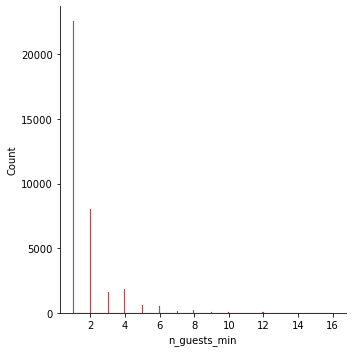

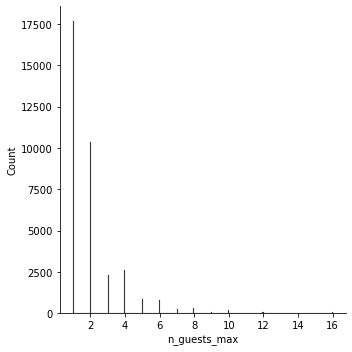

In [67]:
#Distribution plot of n_guests_min and n_guests_max
sns.displot(searches, x = 'n_guests_min', color = 'brown')
sns.displot(searches, x = 'n_guests_max', color = 'black')

Both have similar distributions with 1 being the most popular option and 2 being the next popular option. This leads me to believe smaller accomodations would be a good investment for in Dublin.

Next let's find out when are people making these searches. With this we could calculate when do people start thinking about going to Dublin for vacation for ads.

[[None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

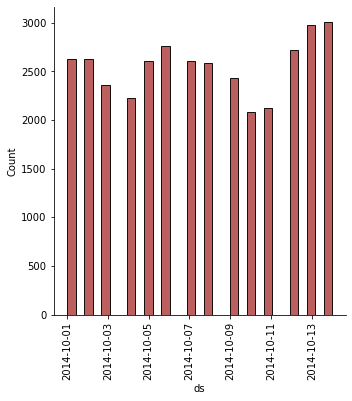

In [68]:
#When were searches conducted

ax = sns.displot(searches, x = 'ds', color = 'brown')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in ax.axes.flat]

Noticed all date searches was between October 1st to October 14th. No major variation between when search was conducted between these dates.

Next let's understand what is the maximum price people are willing to pay for a room.
Airbnb's website automatically sets the maximum price as 1073742000 and certain prices are so low in the count that it is negligible. So we set the maximum price with a relevant count as 600. 600 was chosen as the upper limit since only 5.31% of the dataset has values greater than 600.

Filter_price_max was chosen instead of filter_price_min due to the minimum set as $10 on Airbnb's website.

In [69]:
#Percentage of dataset with a filter_price_max above 600

len(searches[searches['filter_price_max'] > 600])/len(searches['filter_price_max'])

0.053110221898872316

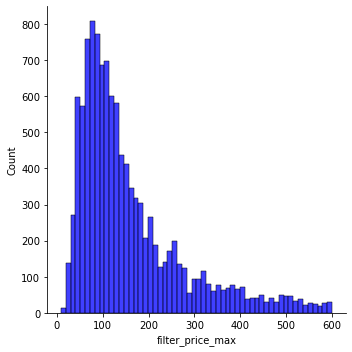

In [70]:
#Distribution of filter_price_max of searches

#Removing the set upper limit
searches_maxprice_removed = searches[searches['filter_price_max'] <= 600]

#Distribution plot of filter_price_max column
sns.displot(x=searches_maxprice_removed["filter_price_max"], color = 'blue')

Most people search for a room below $200/night with most searches around $100/night.
59% of people searched for rooms between $60 and $130 a night.

Let's calculate how long soon people want rooms when booking. First we have to convert the length_preperation column to int data type for filtering. After that search for length_preperations less than 100, since only 9.4% of the dataset exists beyond that.

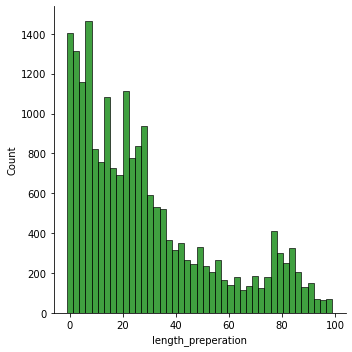

In [71]:
#Distribution of length_preperation of searches

#Percentage of dataset beyond 100 days
distribution = searches["length_preperation"] / np.timedelta64(1, 'D')
len(distribution[distribution > 100])/len(distribution)

#Remove values beyond 100 days
distribution = distribution[distribution < 100]

#Distribution plot of length_preperation column
sns.displot(x=distribution, color = 'green')


Based on this data, around 37% of people search for a room within 2 weeks
23.7% search for rooms within a week
13.46% search for rooms between 1-2 weeks
12.51% search for rooms between 2-3 weeks

Now let's find the distribution of number of nights people want to stay. 
Of course as before, we have to find the upper limit. In this case 4.74% of the dataset exists beyond 20 days, so we chose 20 as upper limit.

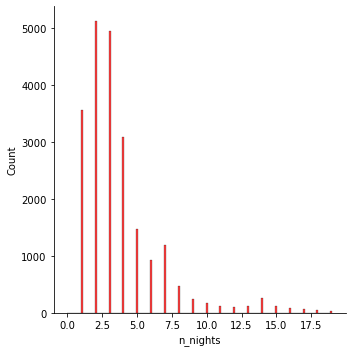

In [72]:
#Distribution of n_nights of searches

#Percentage of dataset beyond 20 nights
len(searches[searches['n_nights'] > 20])/len(searches['n_nights']) 

#Remove n_nights beyond 20 days
searches_within_twenty = searches[searches['n_nights'] < 20]

#Distribution plot of length_preperation column
sns.displot(searches_within_twenty, x='n_nights', color = 'red')

Around 70% of people want to stay between 1-4 days, mostly 2 or 3
People generally don’t want to stay for more than a week (only 15% want to stay more than a week)

Here we are going to calculate when do people want to take a trip to Dublin.

We use the check in date to calculate this.

Used only checkin month, cause checkout is usually within 5 days. The 75% of n_nights is 5, so assumed 5 days after checkin date people usually checkout.

In [73]:
#8 number summary of n_nights column

searches['n_nights'].describe()

count    23888.000000
mean         7.672765
std         21.557614
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        399.000000
Name: n_nights, dtype: float64

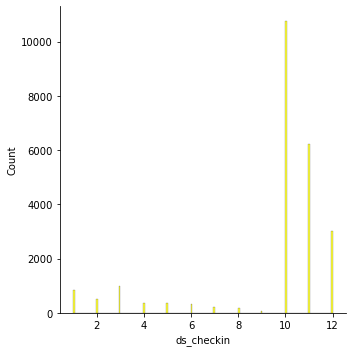

In [74]:
#Distribution of months of ds_checkin of searches

checkin_month = pd.DatetimeIndex(searches['ds_checkin']).month

#Distribution plot of length_preperation column
sns.displot(checkin_month, color = 'yellow')

83.74% of searches were in the October-December

Breakdown:
- 45.05% in October
- 26.1% in November
- 12.6% in December

Now I want to understand which are the most common type of rooms searched for.

In [75]:
#Types of rooms searched for

searches['filter_room_types'].unique()[0:15]

array([',Entire home/apt,Entire home/apt,Private room,Private room', nan,
       ',Entire home/apt',
       'Entire home/apt,Entire home/apt,Private room,Private room',
       'Entire home/apt', ',Shared room,Private room',
       'Entire home/apt,Private room,Shared room,Private room,Shared room',
       'Private room', 'Entire home/apt,Private room', ',Private room',
       ',Entire home/apt,Private room',
       ',Entire home/apt,Private room,Private room',
       'Entire home/apt,Private room,Shared room',
       ',Entire home/apt,Entire home/apt,Private room',
       ',Entire home/apt,Entire home/apt,Shared room,Shared room'],
      dtype=object)

Most of the room types requested were entire home/apt and private room sometimes shared room.
If given more time, I would have cleaned this column since most filter values are actually repeated within the same cell.
On the airbnb website, there are only 4 values in the type of place: 
- Entire Place
- Private Room
- Hotel Room
- Shared Room

So searching how often these 4 strings occur would be how I go about it

There is also the origin_country column which indicates which country the search came from. We could find the most common countries searched from.

In [76]:
#Find top 15 countries where searches originate from

#Group by origin country and finding the count of each country
search_origin = searches.groupby("origin_country").agg({'origin_country' : 'count'})
search_origin.columns = ['count']

search_origin = search_origin.sort_values('count', ascending = False) #Sort count in descending order
search_origin.nlargest(15, 'count') #Find the 15 largest values

,count
origin_country,
IE,6608
US,5811
GB,4832
FR,3444
IT,2333
DE,2170
ES,1759
CA,1085
AU,962


Ireland, US, and Great Britain comprise of 48% of searches
Dublin destinations could be promoted within these 3 countries more for the winter months

## Contacts Dataset

After analyzing the searches dataset, we have to start analyzing the contacts dataset.
First we'll start with the data types of the dataset.

In [77]:
#Datatypes of contacts dataset
contacts.dtypes

id_guest          object
id_host           object
id_listing        object
ts_contact_at     object
ts_reply_at       object
ts_accepted_at    object
ts_booking_at     object
ds_checkin        object
ds_checkout       object
n_guests           int64
n_messages         int64
dtype: object

This shows that multiple columns need to be converted to datatime data type

These columns need to be converted
   - ts_contact_at
   - ts_reply_at
   - ts_accepted_at
   - ts_booking_at
   - ds_checkin
   - ds_checkout
   - accepted

And create length_stay in the contacts dataset as well

In [78]:
#Manipulation of contacts dataset

#Convert date columns to datetime data type 
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['accepted'] = np.where(np.isnan(contacts['ts_accepted_at']), False, True)

contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']

#Understand dataset with describe function
display(contacts.describe())

,n_guests,n_messages,length_stay
count,7823.000000,7823.000000,7823
mean,2.422600,6.319954,5 days 19:25:32.864629937
std,1.617347,6.472827,14 days 23:45:24.447710564
min,1.000000,1.000000,1 days 00:00:00
25%,1.000000,2.000000,2 days 00:00:00
50%,2.000000,4.000000,3 days 00:00:00
75%,3.000000,8.000000,5 days 00:00:00
max,16.000000,102.000000,334 days 00:00:00


In [79]:
#Calculate skewness in contacts dataset

display(contacts.skew(axis = 0, numeric_only = True, skipna = True))

n_guests      2.441468
n_messages    3.696440
accepted      0.145883
dtype: float64

All columns have a Fisher-Pearson coefficient value greater than 1.
Except for accepted, which could be due to it being a derived from an existing column.
With more time, I would have used a transformation method such as box-cox to reduce the skewness.

Finding the distribution of number guests staying

This would be useful in comparing how many guests were searched for vs how many guests the room was booked for

Choosing less than 8 guests, since only 1.46% (114 values) of the contacts dataset has 8 or more guests. To better visualize the majority distribution we removed rows with 8 or more guests.

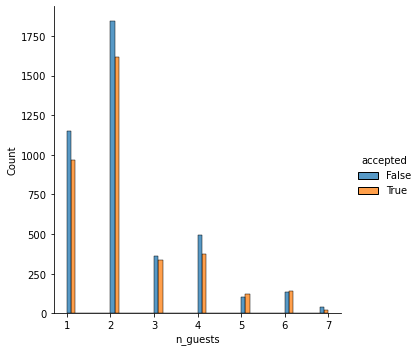

In [80]:
#Number of guests stayed

contacts_less8 = contacts[contacts['n_guests'] < 8]
sns.displot(contacts_less8, x = 'n_guests', hue = 'accepted', multiple="dodge")

2 guests is the most popular option to book, but 1 guest is the most popularly searched option. This leads me to believe there is a lack of supply of viable single guest rooms.

Another thought I had was if there was a correlation between number of guests vs how long people stayed

I took the average length stay by number of guests who were accepted/not-accepted.

In [81]:
#Check average length of stay by n_guests of the applications

contacts.groupby(["n_guests", "accepted"]).agg({'length_stay' : ['mean', 'count']})

#Using count here to find if there is enough data to support any claims made about the average length_stay.

length_stay      
                                       mean count
n_guests accepted                                
1        False    8 days 07:04:51.383812010  1149
         True     5 days 21:18:50.362694300   965
2        False    5 days 21:33:11.323210412  1844
         True     4 days 17:08:49.542645241  1618
3        False    9 days 11:56:01.325966850   362
         True     6 days 21:26:37.633136094   338
4        False    4 days 08:04:52.089249492   493
         True     3 days 22:47:25.623342175   377
5        False    3 days 02:21:10.588235294   102
         True        3 days 12:05:45.600000   125
6        False    4 days 00:42:59.104477611   134
         True     3 days 05:18:51.428571428   140
7        False    2 days 23:22:06.315789473    38
         True               3 days 04:00:00    24
8        False              3 days 10:30:00    32
         True     3 days 11:28:41.739130434    23
9        False              2 days 00:00:00     2
         True               4 days 00:00:00     1
10       False              3 days 12:00:00    16
         True               3 days 15:00:00     8
11       False              2 days 08:00:00     3
         True               3 days 12:00:00     2
12       False              2 days 18:00:00    12
         True               9 days 08:00:00     3
13       False              2 days 00:00:00     1
         True               3 days 12:00:00     2
15       False              3 days 00:00:00     4
16       False              5 days 00:00:00     4
         True               2 days 00:00:00     1

As seen, the length_stay is usually around a day more for single guests compared to 2 guests. People in small groups (1-3 size) stay for around 5 days. I don't think a safe assumption can be made about length of stay of guests with 5 or more due to lack of data. But it does seem that guests with 5 or more generally stay 3/4 days need to research further once data is available.

Another interesting fact is that people who ask for a longer length_stay are rejected at a higher rate. For 1 guest, the average accepted application is a little under 6 days while rejected ones is 8 days. For all n_guests until 5, the average rejected length_stay is greater than average accepted length_stay.

I was also wondering how many acceptance actually is converted into booking the room.

In [82]:
#Conversion rate from accepting to booking

contacts['ts_booking_at'].count()/contacts['ts_accepted_at'].count()


0.5993934381031155

As seen before during the common check in dates, the popular dates are October-December.
Finding if there happens to be major difference people rejected vs accepted.

([<matplotlib.axis.XTick at 0x7fe298752370>,
 [Text(9.75, 0, '9.75'), Text(10.0, 0, '10.00'), Text(10.25, 0, '10.25')])

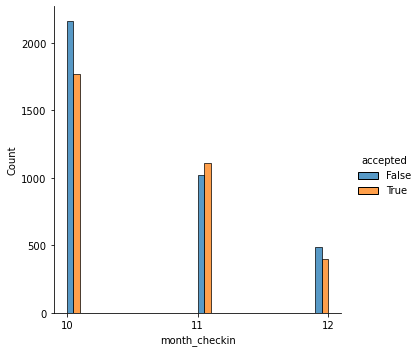

In [83]:
#Timeframe of when guests or accepted vs rejected

contacts['month_checkin'] = contacts['ds_checkin'].dt.month #Extract month from checkin date
contacts_checkin = contacts[contacts['month_checkin'] > 9] #Use only peak season months (Oct, Nov, Dec)

#Distribution of checkin among October, November, and December and split by acceptance
sns.displot(contacts_checkin, x='month_checkin', hue = 'accepted', multiple="dodge")
plt.xticks([10, 11, 12])

There does not appear to be any major variation between accepted vs rejected users

Often you have to merge datasets to get peform faster analysis. 
We'll merge the searches and contacts datasets for further analysis.

In [84]:
#Merge datasets for more analysis

merged_datasets = contacts.merge(searches, left_on='id_guest', right_on='id_user')

Let's check if the maximum price people are willing to pay affects the acceptance/rejection rates.

To further help better visualize the trend we set the filter price max as less or equal to 600.
600 was chosen as the limit since only 14.25% of the dataset has values greater than 600.

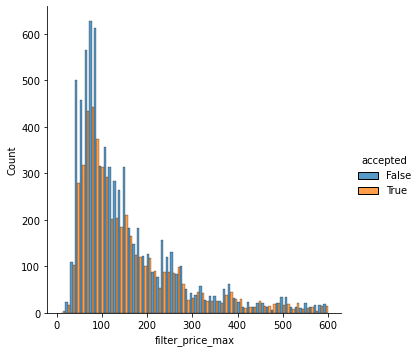

In [85]:
#Check difference between prices searched between accepted/rejected applicants

merged_pricemax_filter = merged_datasets.loc[(merged_datasets['filter_price_max'] <= 600)]

sns.displot(merged_pricemax_filter, x="filter_price_max", hue="accepted", multiple="dodge")

In [86]:
#Classify dataset based on filter_price_max

def label_price (row):
    if (row['filter_price_max'] >= 0) & (row['filter_price_max'] < 100):
        return '0-100'
    
    elif (row['filter_price_max'] >= 100) & (row['filter_price_max'] < 200):
        return '100-200'

    elif (row['filter_price_max'] >= 200) & (row['filter_price_max'] < 300):
        return '200-300'
    
    elif (row['filter_price_max'] >= 300) & (row['filter_price_max'] < 400):
        return '300-400'

    elif (row['filter_price_max'] >= 400) & (row['filter_price_max'] < 500):
        return '400-500'
    
    elif (row['filter_price_max'] >= 500) & (row['filter_price_max'] < 600):
        return '500-600'
    
    else:
        return '600+'

merged_datasets['classification_max_price'] = merged_datasets.apply(lambda row: label_price(row), axis=1)

merged_datasets.groupby('classification_max_price').agg({'accepted': 'mean'})

,accepted
classification_max_price,
0-100,0.411160
100-200,0.430308
200-300,0.431149
300-400,0.450488
400-500,0.485549
500-600,0.422297
600+,0.433122


Based on this table, it can be seen that regardless of max_filter_price, people are rejected at similar rates around 43%

One of the few details the Airbnb hosts see about the potential guests is their hometown from their profile information.

I'm curious to see if there is any difference in acceptance rate by country. 

In [87]:
#Find the acceptance rate by country

dataset_country = merged_datasets[['origin_country', 'accepted']]

#Find acceptance count by country and accepted
accepted_count = dataset_country.groupby(['origin_country', 'accepted']).agg({'origin_country':'count'})
accepted_count.columns = ['count_accepted']

#Find acceptance count by country
country_count = dataset_country.groupby(['origin_country']).agg({'origin_country':'count'})
country_count.columns = ['count_country']

#Merge datasets for easier manipulation 
acceptance_country = pd.merge(dataset_country, accepted_count,  how='left', on=['origin_country','accepted']) #Merge accepted count
acceptance_country = acceptance_country.drop_duplicates()

acceptance_country = pd.merge(acceptance_country, country_count, how='left', on=['origin_country']) #Merge total country count
acceptance_country = acceptance_country.sort_values(['count_country', 'accepted'], ascending = [False, True])
acceptance_country = acceptance_country[acceptance_country['count_country'] >= 100] #100 is used so there is a good amount of data to make assumptions
acceptance_country = acceptance_country[acceptance_country['accepted'] == True]

#Divide count_accepted column by count_country column to find acceptance rate by country
acceptance_country['acceptance_rate'] = acceptance_country['count_accepted']/acceptance_country['count_country']
acceptance_country.sort_values(['acceptance_rate'], ascending = True)

,origin_country,accepted,count_accepted,count_country,acceptance_rate
73,IN,True,138,874,0.157895
55,HR,True,159,530,0.300000
72,AT,True,83,239,0.347280
54,RU,True,83,239,0.347280
11,IT,True,1183,3137,0.377112
100,AE,True,59,154,0.383117
0,CA,True,407,993,0.409869
13,IE,True,1217,2951,0.412403
24,ES,True,794,1914,0.414838
49,RO,True,50,118,0.423729


Interesting point is that India only has the lowest acceptance rate of 15%, which is half of the acceptance rate compared to the second lowest accepted country.

There could be a potential market in Denmark, which can be seen through highest acceptance rate but low application numbers. Increasing marketing in this country could increase demand.

Needs to be investigated further